This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/odometry.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [2]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [3]:
import torch
import numpy as np
import pandas as pd

from typing import Dict, List, Tuple, Optional
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [4]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry

In [5]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
VALIDATION_FOLDER = EXPERIMENT_FOLDER / 'validation-recordings'
MODELS_FOLDER = Path().resolve().parent / 'models'
print(MODELS_FOLDER)

/Users/esdandreu/Desktop/AO/models


## Generate recording ground truth

The recording is composed by audio files from several devices that span for the
whole experiment and several wheel test bed control files that span for certain
parts of the experiment. In this section we combine the control files in order
to generate a unique ground truth for the whole recording.

In [6]:
recording = VALIDATION_FOLDER / 'date_2022-05-20;time_16-59-56'

def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('microphone*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp

get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

In [11]:
def generate_recording_ground_truth(recording: Path) -> pd.DataFrame:
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.loc[:, 'X'] /= 1000 # [mm] -> [m]
    gt['tx'] = gt['X'].diff()
    gt.iloc[0, gt.columns.get_loc('tx')] = 0
    return gt

,X,Vx,Vw,slip,wheel_rotation,tx
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.000000,0.00000
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.002397,0.00000
1.653034e+09,0.00011,0.0011,7.0113,0.91011,0.703520,0.00011
1.653034e+09,0.00129,0.0118,9.8078,0.31066,1.684300,0.00118
1.653034e+09,0.00371,0.0242,10.1710,-0.36320,2.701400,0.00242


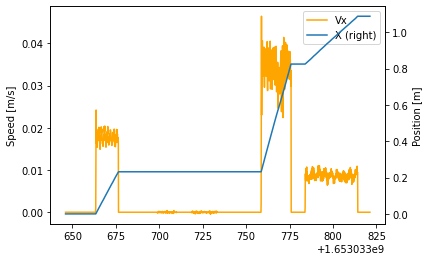

In [10]:
def get_recording_ground_truth(
        recording: Path, force_generation: bool = False
    ) -> pd.DataFrame:
    ground_truth_path = recording / 'ground_truth.csv'
    if not force_generation and ground_truth_path.exists():
        gt = pd.read_csv(ground_truth_path, index_col='timestamp')
    else:
        gt = generate_recording_ground_truth(recording)
        gt.to_csv(ground_truth_path, index_label='timestamp')
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ax = ground_truth.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
ground_truth.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
ground_truth.head()

## Apply model to recording

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cpu device


In [9]:
extractors = [
    ao.extractor.GammatoneFilterbank(
        num_samples=int(10 * 44100 / 1000),
        num_features=256,
        sample_rate=44100,
        )
    ]
model = ao.AO(
    model_path=MODELS_FOLDER /
    'torch-script;name_numpy-arrays;date_2022-05-23;time_13-39-14.pt',
    extractors=extractors,
    num_frames=120,
    )

In [10]:
def generate_odometry(wav_file: Path, model: ao.AO) -> pd.DataFrame:
    """Generates odometry from a wav file using the provided model

    Args:
        wav_file (Path): Audio recording in wav format
        model (ao.AO): Acoustic Odometry model

    Returns:
        pd.DataFrame: Odometry data with columns 'Vx', 'tx' and 'X'
    """
    wav_data, _ = ao.io.wave_read(wav_file)
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    start = config['start_timestamp']
    step = model.num_samples / model.sample_rate
    frames = ao.dataset.audio._frames(
        wav_data.mean(axis=1)[:, np.newaxis], model.num_samples
        )
    timestamps = np.linspace(start, start + len(frames) * step, len(frames))
    Vx = np.zeros(len(frames))
    for i, frame in tqdm(enumerate(frames), total=len(frames), unit='frames'):
        Vx[i] = model(frame)
    # Compute X translations and cumulative X position
    Vx = pd.Series(Vx, index=timestamps) / 100  # [cm/s] -> [m/s]
    odom = pd.concat([Vx, Vx.index.to_series().diff() * Vx], axis=1)
    odom.columns = ['Vx', 'tx']
    odom.iloc[0, :] = 0
    odom['X'] = odom['tx'].cumsum()
    return odom

  0%|          | 0/17307 [00:00<?, ?frames/s]

KeyboardInterrupt: 

In [ ]:
def get_odometry(
        wav_file: Path,
        model: ao.AO,
        force_generation: bool = False
    ) -> pd.DataFrame:
    odometry_path = wav_file.parent / str(model) / wav_file.name.with_suffix(
        '.odometry.csv'
        )
    if not force_generation and odometry_path.exists():
        odom = pd.read_csv(odometry_path, index_col='timestamp')
    else:
        odom = generate_odometry(wav_file, model)
        odom.to_csv(odometry_path, index_label='timestamp')
    return odom


odom = get_odometry(wav_file=recording / f'microphone0.wav', model=model)
odom.head()

## Evaluate the results

In [ ]:
def evaluate_odometry(
        odom: pd.DataFrame, ground_truth: pd.DataFrame
    ) -> Dict[str, float]:
    """Evaluates the provided odometry data against the ground truth

    Args:
        odom (pd.DataFrame): Odometry data with at least columns 'tx', 'X' and
            timestamps as index
        ground_truth (pd.DataFrame): Ground truth data with at least columns
            'tx', 'X' and timestamps as index

    Returns:
        Dict[str, float]: Evaluation metrics dictionary
    """
    ts = odom.index.to_numpy()
    gt_ts = ground_truth.index.to_numpy()
    # Interpolate ground truth to estimation timestamps
    sync_gt_tx = np.interp(ts, gt_ts, ground_truth['tx'].to_numpy())
    sync_gt_X = np.interp(ts, gt_ts, ground_truth['X'].to_numpy())
    odom['tx_error'] = np.absolute(sync_gt_tx - odom['tx'].to_numpy())
    odom['X_error'] = np.absolute(sync_gt_X - odom['X'].to_numpy())
    return {
        'ATE': odom['tx_error'].mean(),
        'MPE': odom['X_error'].max(),
    }

In [ ]:
def plot_odometry_evaluation(
    odom: pd.DataFrame,
    ground_truth: pd.DataFrame,
    recording_config: Optional[Dict[str, Any]] = None,
    metrics: Optional[Dict[str, float]] = None,
    ) -> Tuple[plt.Figure, List[plt.Axes]]:
    """_summary_

    Args:
        odom (pd.DataFrame): _description_
        ground_truth (pd.DataFrame): _description_
        recording_config (Optional[Dict[str, Any]], optional): _description_.
            Defaults to None.
        metrics (Optional[Dict[str, float]], optional): _description_. Defaults
            to None.

    Returns:
        Tuple[plt.Figure, List[plt.Axes]]: _description_
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title('Acoustic Odometry')
    ax = odom.plot(ax=axs[0], y=['Vx'], ylabel='Speed [m/s]', color='orange')
    odom.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
    axs[1].set_title('Speed validation')
    ax = ground_truth.plot(
        ax=axs[1],
        y=['Vx'],
        ylabel='Speed [m/s]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['Vx'], label=['Acoustic Odometry'])
    axs[2].set_title('Position validation')
    ax = ground_truth.plot(
        ax=axs[2],
        y=['X'],
        ylabel='Position [m]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['X'], label=['Acoustic Odometry'])
    if recording_config is not None:
        
    fig.tight_layout()
    return fig, axs


_ = plot_odometry_evaluation(odom, ground_truth)

NameError: name 'pd' is not defined

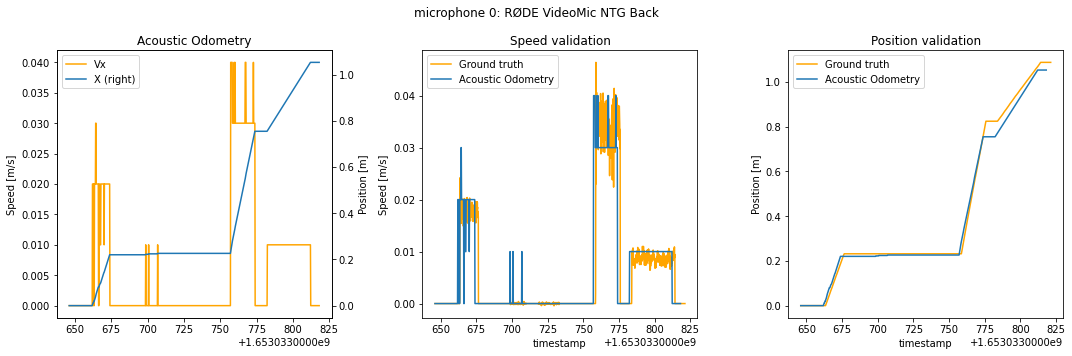

In [ ]:
def evaluate_model(
    model: ao.Ao,
    wav_file: Path,
    ground_truth: Optional[pd.DataFrame] = None,
    ) -> pd.DataFrame:
    # Get ground truth and config
    if ground_truth is None:
        ground_truth = get_recording_ground_truth(recording=wav_file.parent)
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    # Generate odometry
    odom = generate_odometry(wav_file, model)
    # Add errors to odometry
    metrics = evaluate_odometry(odom, ground_truth)
    # TODO save evaluation to file
    return odom

In [ ]:
def get_model_evaluation(model: ao.Ao, wav_file: Path) -> pd.DataFrame:
    return evaluate_model(model, wav_file)

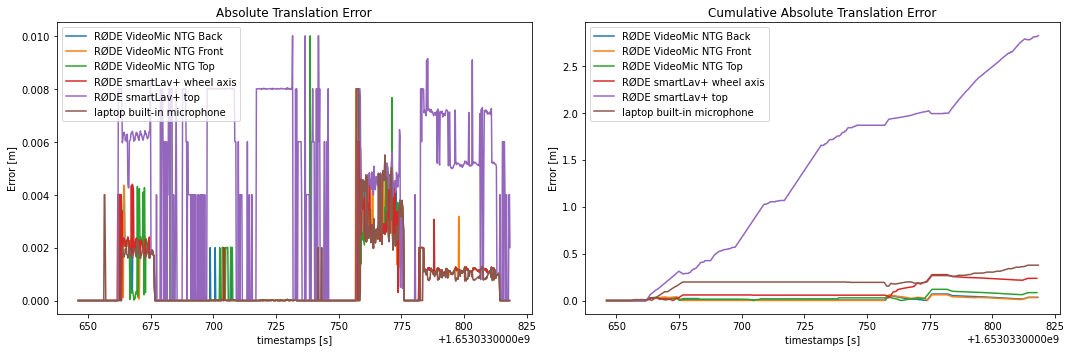

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax, get_x, title in zip(
    axs, [lambda x: x['error'], lambda x: x['cumulative_error']],
    ['Absolute Translation Error', 'Absolute Position Error']
    ):
    for result in ATE.values():
        ax.plot(
            result['timestamps'],
            get_x(result),
            label=result['config']['name']
            )
    ax.set_ylabel('Error [m]')
    ax.set_xlabel('timestamps [s]')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

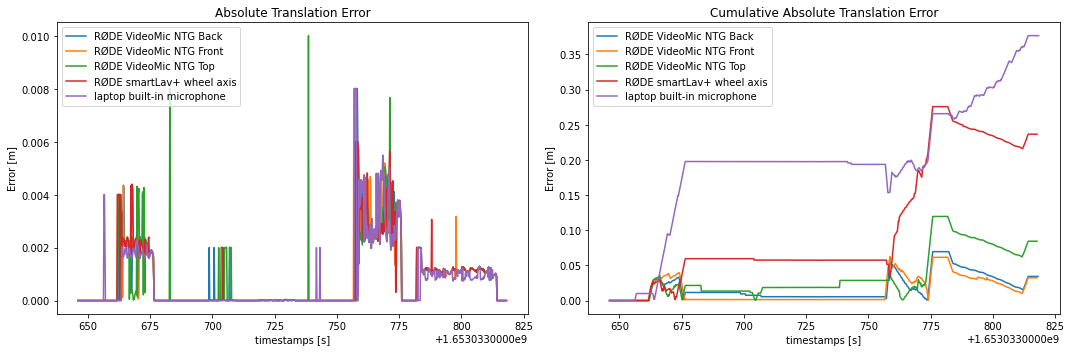

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax, get_x, title in zip(
    axs, [lambda x: x['error'], lambda x: x['cumulative_error']],
    ['Absolute Translation Error', 'Absolute Position Error']
    ):
    for mic, result in ATE.items():
        if mic == 4:
            continue
        ax.plot(
            result['timestamps'],
            get_x(result),
            label=result['config']['name']
            )
    ax.set_ylabel('Error [m]')
    ax.set_xlabel('timestamps [s]')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


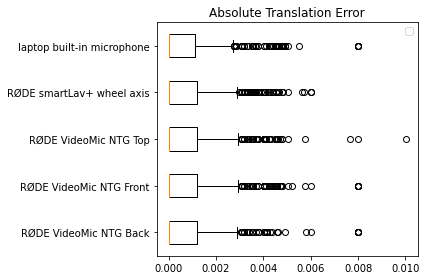

In [ ]:
fig, ax = plt.subplots(1, 1)
results_to_plot = [result for mic, result in ATE.items() if mic != 4]
ax.boxplot(
    [result['error'] for result in results_to_plot],
    labels=[result['config']['name'] for result in results_to_plot],
    vert=False
    )
ax.set_title('Absolute Translation Error')
ax.legend()
fig.tight_layout()

# Validation

## Contact No-Contact